# Identify Alleles with Cell Count Differences

In [2]:
# Imports
import os
import warnings
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel, ttest_ind
import sys
sys.path.append("../..")
from img_utils import *

## 1. Summarize Cell Count Profiles

### 1.1 Allele Metadata

In [3]:
allele_meta_df = pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = pl.read_csv(f"{IMGS_QC_METRICS_DIR}/{bio_rep}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = img_well_qc_sum.with_columns(
        pl.col("channel").replace("DAPI", "DNA").alias("channel")
    )
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio")
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

### 1.2 Cell Count Profiles

In [4]:
well_profiles = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    combined_profiles_batch = pl.DataFrame()
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                f"{PROF_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
            )
            .select([
                "Metadata_gene_allele",
                "Metadata_Well",
                "Metadata_Plate",
            ])
        )
        combined_profiles_batch = pl.concat([combined_profiles_batch, batch_alleles.collect()])
    
    ## Get the cell count per allele in each well
    well_profiles_batch = combined_profiles_batch.group_by([
        "Metadata_Well", "Metadata_Plate", "Metadata_gene_allele"
    ]).len().rename({"len": "Cell_count"})
    # print(well_profiles_batch.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele"))
    
    img_well_qc_sum = img_well_qc_sum_dict[bio_rep]
    img_well_qc_sum_dapi = img_well_qc_sum.filter(pl.col("channel")=="DNA").with_columns(
        pl.col("plate").alias("Metadata_Plate"),
        pl.col("well").alias("Metadata_Well"),
    )
    # display(well_profiles_batch)
    # display(img_well_qc_sum)
    
    well_profiles_batch = well_profiles_batch.join(
        img_well_qc_sum_dapi,
        on=["Metadata_Plate","Metadata_Well"],
        how="left"
    ).select(
        pl.col(["Metadata_Plate","Metadata_Well","Metadata_gene_allele","Cell_count","is_bg"])
    ).with_columns(
        pl.col("Metadata_Plate").str.extract(r"(B[^A]*)", 1).replace(BIO_BATCH_MAP_DICT).alias("Metadata_Bio_Batch")
    ).rename({"is_bg": "dna_is_bg"})
    # print(well_profiles_batch.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele"))
    well_profiles = pl.concat([well_profiles, well_profiles_batch])

print("Original image wells:", well_profiles.shape[0])

Original image wells: 21078


In [5]:
well_profiles = well_profiles.filter(~pl.col("dna_is_bg"))
print("Image wells after QC based on DAPI:", well_profiles.shape[0])

Image wells after QC based on DAPI: 19859


### 1.3 Median/Mean Cell Count by Well Position

<Figure size 640x480 with 0 Axes>

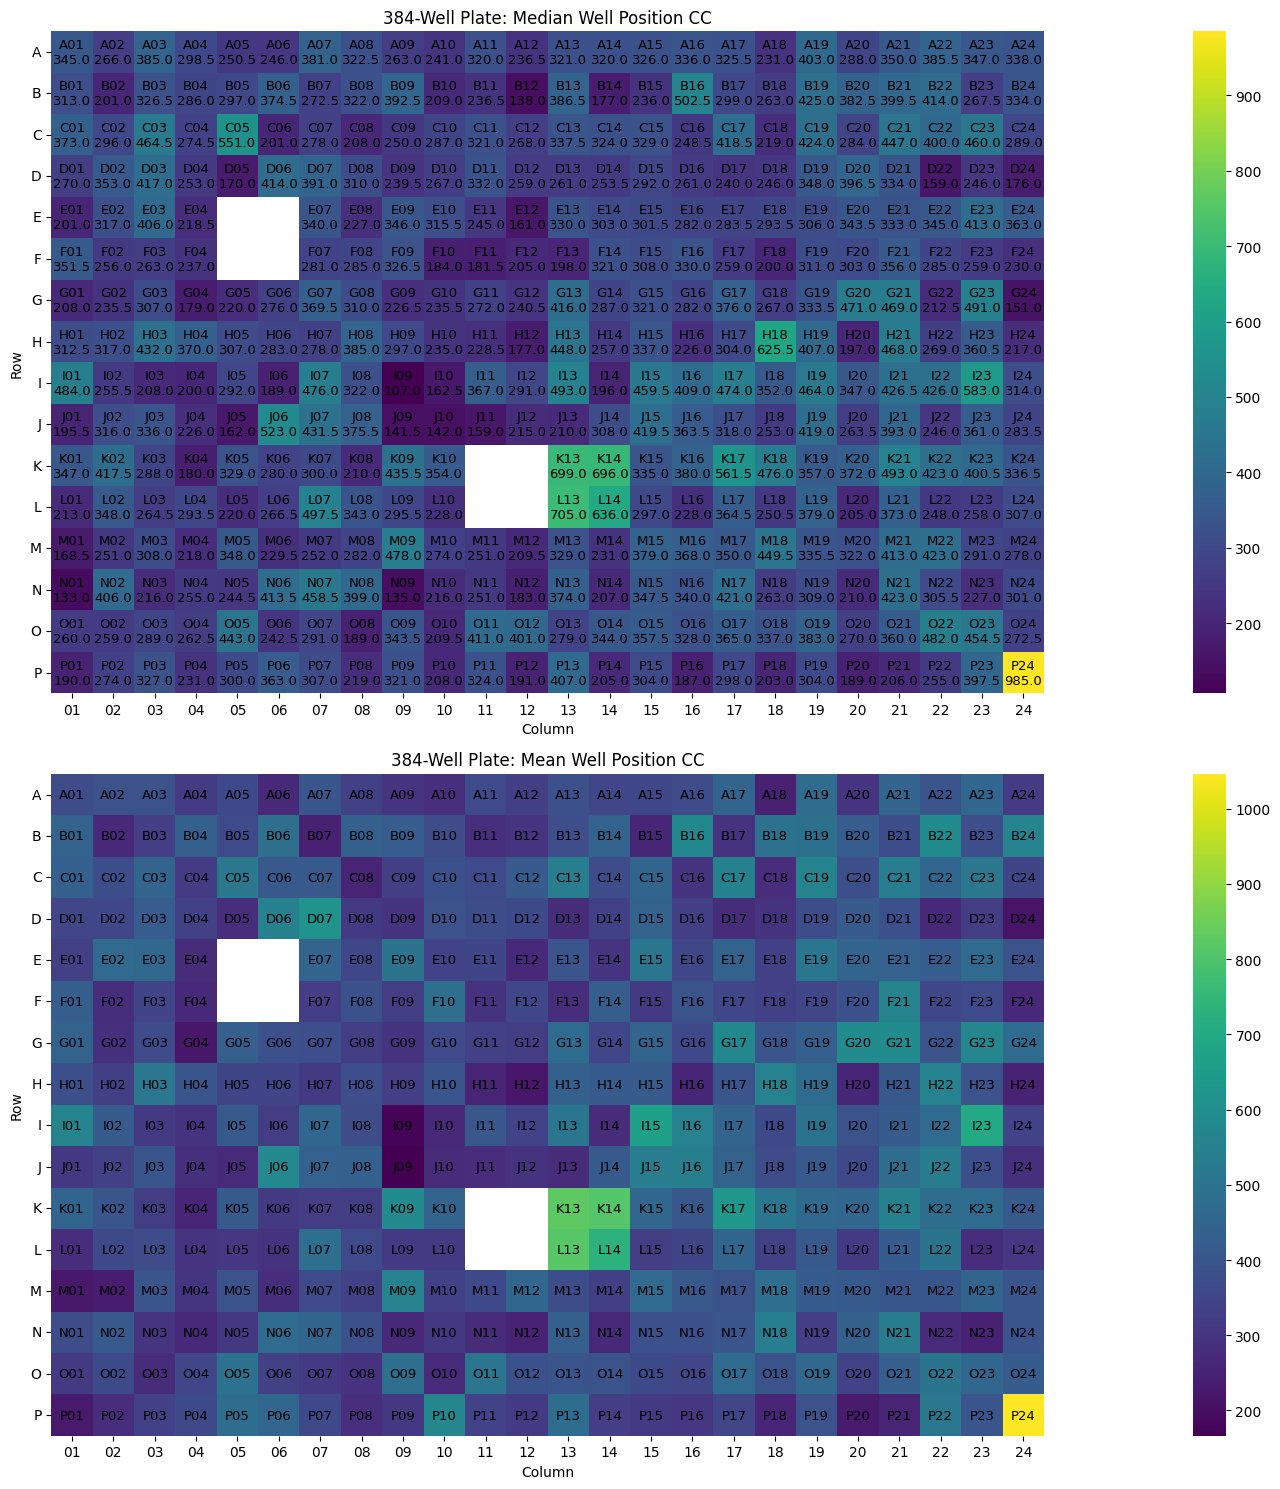

In [6]:
median_well_profile = well_profiles.with_columns(
    pl.col("Metadata_Well").map_elements(well_to_coordinates, return_dtype=pl.List).list.get(1).alias("well_row"),
    pl.col("Metadata_Well").map_elements(well_to_coordinates, return_dtype=pl.List).list.get(2).alias("well_col"),
).group_by("Metadata_Well").agg(
    pl.col("Cell_count").median().alias("CC")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)

mean_well_profile = well_profiles.filter(~pl.col("dna_is_bg")).group_by("Metadata_Well").agg(
    pl.col("Cell_count").mean().alias("CC")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)

plt.clf()
fig, axes = plt.subplots(2,1,figsize=(30,15)) ## sharey=True,sharex=True
plot_platemap(
    median_well_profile,
    "Median Well Position CC",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="CC",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele","CC"),
    ax=axes[0], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)
plot_platemap(
    mean_well_profile,
    "Mean Well Position CC",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="CC",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele",),
    ax=axes[1], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)

fig.subplots_adjust(wspace=-.55, hspace=.05)
plt.tight_layout()
plt.show()

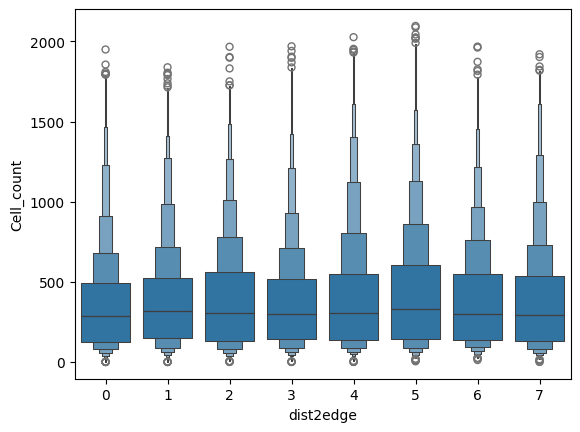

In [7]:
sns.boxenplot(data=well_profiles.with_columns(
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[1], return_dtype=pl.Int16).alias("well_row"),
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[2], return_dtype=pl.Int16).alias("well_col")
).with_columns(
    pl.struct(["well_row", "well_col"])
      .map_elements(lambda s: compute_distance(s["well_row"], s["well_col"]), return_dtype=pl.Int16)
      .alias("dist2edge")
).to_pandas(), x="dist2edge", y="Cell_count")
plt.show()

In [8]:
# def plot_cc_per_plate(well_profile_df):
#     plate_maps = sorted(set(["_".join(plate_map.split("_")[:-1]) for plate_map in sorted(well_profile_df["Metadata_Plate"].unique())]))
#     # print(plate_maps)
#     for plate_map in plate_maps:
#         if (plate_map != "2024_01_17_B7A1R1"):
#             continue
#         plate_map_cc = well_profile_df.filter(pl.col("Metadata_Plate").str.contains(plate_map))
#         plates = sorted(plate_map_cc["Metadata_Plate"].unique().to_list())
#         print(plates)
#         fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#         for plate in plates:
#             plate_info = plate_map_cc.filter(pl.col("Metadata_Plate")==plate)
#             # display(plate_info.filter(pl.col("is_bg")))
#             # print(plates.index(plate))
#             plot_platemap(
#                 plate_info,
#                 plate,
#                 well_pos_col="Metadata_Well",
#                 # this is the column to color by (categorical or continuous)
#                 value_col="Cell_count",
#                 # these columns will be concatenated into the annotation text
#                 label_cols=("Metadata_gene_allele","Cell_count"),
#                 ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 value_type="continuous",   # or "continuous"
#                 continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 grid_square=None
#             )
#         fig.subplots_adjust(wspace=-.55, hspace=.05)
#         plt.tight_layout()
#         plt.show()
#         # break
# plot_cc_per_plate(well_profiles)

In [9]:
# batch_log_files = [
#     f"{CLASS_RES_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/classify.log" \
#     for batch_id in BIO_REP_BATCHES
# ]
# dropped_well_df = pl.DataFrame()
# for logfile in batch_log_files:
#     with open(logfile, encoding="latin-1") as f:
#         lines = f.readlines()
#     dropped_wells = [(l.split(",")[0].strip(), l.split(",")[1].strip()) for l in lines if l.startswith("2025")]
#     dropped_well_df = pl.concat([dropped_well_df, 
#                                  pl.DataFrame({"plate": [well[0] for well in dropped_wells],
#                                                "imaging_well": [well[1].split(":")[0] for well in dropped_wells],
#                                                "gene_allele": [well[1].split(":")[1] for well in dropped_wells]})])
# # dropped_well_df.filter(pl.col("gene_allele").is_in(img_well_qc_sum_dapi.filter(pl.col("is_bg"))["gene_allele"].unique()))

## 2. Cell Count Change Detection

### 2.1 Paired T-test

In [10]:
from scipy.stats import shapiro
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel

MIN_NUMBER_REP = 3

In [11]:
def paired_ttest(dat, reference: str, var: str):
    ## perform stat test
    ## sorted the two alleles to make sure they are from the same plate for paired t-test    
    # if (dat[dat["Metadata_gene_allele"]==reference].shape[0] != dat[dat["Metadata_gene_allele"]==var].shape[0]):
    # pivot to wide: one row per plate
    wide_cc = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values="Cell_count")
    # print(wide_cc)
    # drop any plate that doesn’t have both measurements
    wide_cc = wide_cc.dropna(subset=[reference, var])
    if wide_cc.shape[0] >= MIN_NUMBER_REP:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_cc[var].astype(int), wide_cc[reference].astype(int))
    else:
        t_stat, p_val = None, None

    # df_sampled["PlateID"] = df_sampled["Metadata_Plate"].str.extract(r"(P\d+T\d+)", expand=False)
    ## adjust for edge effect
    # dat["dist2edge"] = dat["Metadata_Well"].apply(lambda x: compute_distance(well_to_coordinates(x)[1], well_to_coordinates(x)[2]))
    # fit Cell_count ~ dist2edge
    # m0 = smf.ols("Cell_count ~ dist2edge", data=dat).fit()
    # dat["resid"] = m0.resid
    # ## calc t-test on residuals corrected for distance to edge
    # wide_res = dat.pivot(index="Metadata_Plate",
    #                     columns="Metadata_gene_allele",
    #                     values="resid")
    # # drop any plate that doesn’t have both measurements
    # wide_res = wide_res.dropna(subset=[reference, var])
    # if wide_res.shape[0] >= 3:
    #     # now run paired t-test
    #     res_t_stat, res_p_val = ttest_rel(wide_res[reference], wide_res[var])
    # else:
    #     res_t_stat, res_p_val = None, None
    
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            # "t_stat_res": res_t_stat,
            # "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df


def ind_ttest(dat, reference: str, var: str):
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    ## sort the wells to make sure they are from the same plate
    df_sampled = pd.DataFrame()
    for plate in dat["Metadata_Plate"].unique():
        dat = dat[dat["Metadata_Plate"]==plate].dropna().sort_values(["Metadata_gene_allele"])
        # count rows per group
        group_counts = dat.groupby("Metadata_gene_allele").size()
        min_count = group_counts.min()
        # print("Minimum rows in any group:", min_count)
        shuffled = dat.sample(frac=1, random_state=42).reset_index(drop=True)
        # Then take the first min_count rows per group
        sampled_df2 = (
            shuffled
            .groupby("Metadata_gene_allele", group_keys=False)
            .head(min_count)
        )
        df_sampled = pd.concat([df_sampled, sampled_df2])

    # m0 = smf.ols("Cell_count ~ Metadata_Well", data=df_sampled).fit()
    # df_sampled["resid"] = m0.resid
    # print(df_sampled)
    ## require at least two alleles per each VAR and WT group
    if df_sampled.shape[0] >= MIN_NUMBER_REP * 2:
        # now run paired t-test
        t_stat, p_val = ttest_ind(
            df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "Cell_count"].astype(int).values,
            df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "Cell_count"].astype(int).values, 
            equal_var=False
        )
        # res_t_stat, res_p_val = ttest_ind(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "resid"].values, 
        #                                   df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "resid"].values,
        #                                   equal_var=False)
    else:
        t_stat, p_val = None, None
        # res_t_stat, res_p_val = None, None
        
    # break
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            # "t_stat_res": res_t_stat,
            # "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

In [12]:
well_cc_stats = []
tested_variants = allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])["gene_allele"]
print(len(tested_variants))

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele or allele not in tested_variants:
        continue

    reference = allele.split("_")[0]
    temp_prof_var = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well","Metadata_Bio_Batch","Cell_count"])
    ).to_pandas()

    bio_batch_list = list(temp_prof_var["Metadata_Bio_Batch"].unique())
    # if (len(bio_batch_list) > 1):
    #     print(bio_batch_list)
    #     print(allele)
        # print(temp_prof_var)
    for bio_batch in bio_batch_list:
        temp_prof = temp_prof_var[temp_prof_var["Metadata_Bio_Batch"]==bio_batch]
        if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
            # print(temp_prof)
            continue
            
        var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
        ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
        temp_prof = pd.concat([var_profiles, ref_profiles])
        # if allele == "DES_Ser46Tyr":
        #     display(temp_prof)
        
        # print(batch_plate)
        ## Select ONLY the wells most distant from the edge per each allele to minimize the well-position edge effects
        ## deprecated: let's compare every pair
        # if (ref_profiles.shape[0] > var_profiles.shape[0]):
        #     ref_al_wells = ref_profiles["Metadata_Well"].unique()
        #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        #     # Sort wells by max distance from edges (descending)
        #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        #     ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
        # if (ref_profiles.shape[0] < var_profiles.shape[0]):
        #     ref_al_wells = var_profiles["Metadata_Well"].unique()
        #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        #     # Sort wells by max distance from edges (descending)
        #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        #     var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

        if (bio_batch == "B_11-12"):
            ind_t_res = ind_ttest(
                dat=temp_prof,
                reference=reference,
                var=allele
            ).with_columns(
                pl.lit("").alias("Ref_well"),
                pl.lit("").alias("Var_well"),
                pl.lit(bio_batch).alias("Bio_Batch")
            )
            well_cc_stats.append(
                ind_t_res
            )
            # print(ind_t_res)
            # break
        else:
            ref_wells = ref_profiles["Metadata_Well"].unique()
            var_wells = var_profiles["Metadata_Well"].unique()
            ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
            # print(ref_var_pairs)
            
            ## Per each ref-var well pair on the SAME plate, use paired-t-test to detect differences in CC
            for ref_var in ref_var_pairs:
                ## sort the wells to make sure they are from the same plate
                df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(
                    ["Metadata_Plate", "Metadata_gene_allele"]
                )
                paired_t_res = paired_ttest(
                    dat=df_sampled,
                    reference=reference,
                    var=allele
                ).with_columns(
                    pl.lit(ref_var[0]).alias("Ref_well"),
                    pl.lit(ref_var[1]).alias("Var_well"),
                    pl.lit(bio_batch).alias("Bio_Batch")
                )
                # if allele == "LDLR_Pro196Thr":
                #     display(df_sampled)
                #     display(paired_t_res)
                    
                well_cc_stats.append(
                    paired_t_res
                )
        
well_cc_stats = pl.concat(well_cc_stats,  how="vertical_relaxed")
well_cc_stats = well_cc_stats.rename({"t_stat": "U2OS_t_stat", "p_val": "U2OS_t_pval"}) ## "t_stat_res": "U2OS_paired_tstat_edgedist_resid", "p_val_res": "U2OS_t_edgedist_resid_pval"
well_cc_stats = well_cc_stats.select(["Gene", "Variant", "U2OS_t_stat", "U2OS_t_pval", 
                                      "Ref_well", "Var_well", "Bio_Batch"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",
display(well_cc_stats)

1808


100%|██████████| 2124/2124 [00:21<00:00, 100.42it/s]


Gene,Variant,U2OS_t_stat,U2OS_t_pval,Ref_well,Var_well,Bio_Batch
str,str,f64,f64,str,str,str
"""KRT8""","""KRT8_Ile63Val""",-3.378269,0.01489,"""L08""","""B10""","""B_7-8"""
"""IL36RN""","""IL36RN_Leu27Pro""",5.322175,0.001097,"""G02""","""I02""","""B_15-16"""
"""SERPINF1""","""SERPINF1_Thr72Met""",-1.992013,0.093455,"""L20""","""N20""","""B_7-8"""
"""NFU1""","""NFU1_Gly208Cys""",1.881863,0.108873,"""C08""","""E08""","""B_7-8"""
"""MVK""","""MVK_Val250Ile""",3.200225,0.018595,"""C15""","""K21""","""B_7-8"""
…,…,…,…,…,…,…
"""GBA""","""GBA_Asn98Thr""",-1.378017,0.210634,"""M09""","""C21""","""B_18-19"""
"""GBA""","""GBA_VAL54LEU""",-3.000347,0.019932,"""M09""","""H05""","""B_18-19"""
"""GBA""","""GBA_Arg296Ter""",5.357956,0.001055,"""M09""","""G15""","""B_18-19"""


In [13]:
display(well_cc_stats.sort(by="U2OS_t_stat", descending=False))
# Correct p-values???
# from statsmodels.stats.multitest import multipletests

Gene,Variant,U2OS_t_stat,U2OS_t_pval,Ref_well,Var_well,Bio_Batch
str,str,f64,f64,str,str,str
"""UBQLN2""","""UBQLN2_Pro497His""",null,null,"""J13""","""P13""","""B_7-8"""
"""MSH2""","""MSH2_Arg96His""",null,null,"""I13""","""M13""","""B_7-8"""
"""DES""","""DES_Ser46Tyr""",null,null,"""J21""","""P10""","""B_7-8"""
"""STAC3""","""STAC3_Trp245Ser""",null,null,"""K19""","""M19""","""B_7-8"""
"""KRT4""","""KRT4_Glu449Lys""",null,null,"""P23""","""P23""","""B_7-8"""
…,…,…,…,…,…,…
"""CALM3""","""CALM3_Asp96His""",29.635715,1.2833e-8,"""O03""","""G05""","""B_18-19"""
"""TMEM43""","""TMEM43_Thr277Ser""",31.962643,7.5866e-9,"""L21""","""N21""","""B_15-16"""
"""PPP1CB""","""PPP1CB_Glu183Ala""",38.176631,2.2015e-9,"""N04""","""J06""","""B_18-19"""


## 3. Summarize Results

In [14]:
## drop the null alleles
well_cc_stats = well_cc_stats.filter(
    pl.col("Gene")!="CCM2",
    pl.col("Bio_Batch")!="B_18-19",
    pl.col("U2OS_t_stat").is_not_null()
)

## extract the alleles with only single appearance
variants_single = well_cc_stats.group_by("Variant").len().filter(pl.col("len")==1)["Variant"]
well_cc_stats_single = well_cc_stats.filter(pl.col("Variant").is_in(variants_single))

## extract the alleles with replicates
variants_replicate = well_cc_stats.group_by("Variant").len().filter(pl.col("len")>1).unique(subset="Variant")["Variant"]
well_cc_stats_rep = well_cc_stats.filter(pl.col("Variant").is_in(variants_replicate))

## check the consistency between replicates
well_cc_stats_rep_group = well_cc_stats_rep.group_by("Variant").agg(
    pl.len().alias("count"),
    (pl.col("U2OS_t_stat")<0).sum().alias("desc"),
    (pl.col("U2OS_t_stat")>0).sum().alias("incr")
)
inconsistent_alleles = well_cc_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr")))
print("Inconsistent CC change across replicates:", inconsistent_alleles)
display(inconsistent_alleles)

## HARD Code to filter bad quality measurements if needed
# well_cc_stats_rep = well_cc_stats_rep.filter(
#     ~((pl.col("Variant")=="MVK_Pro288Leu")&(pl.col("Bio_Batch")=="B_7-8")) &
#     # ~((pl.col("Variant")=="AGXT_Asp201Asn")&(pl.col("Bio_Batch")=="B_7-8")) &
#     ~((pl.col("Variant")=="GSS_Arg125Cys")&(pl.col("Bio_Batch")=="B_7-8")) &
#     ~((pl.col("Variant")=="DES_Pro419Ser")&(pl.col("Var_well")=="B12"))
# )
# display(well_cc_stats_rep.filter(pl.col("Variant").is_in(inconsistent_alleles["Variant"].unique())))

## No problem them merge by mean
well_cc_stats_rep = well_cc_stats_rep.group_by(["Gene","Variant"]).agg(
    pl.col("U2OS_t_stat").mean().alias("U2OS_t_stat"),
    pl.col("U2OS_t_pval").mean().alias("U2OS_t_pval")
).with_columns(
    pl.when(pl.col("Variant").is_in(inconsistent_alleles["Variant"].unique()))
    .then(pl.lit(1))
    .otherwise(pl.col("U2OS_t_pval"))
    .alias("manual_adj_pval")
)

Inconsistent CC change across replicates: shape: (29, 4)
┌─────────────────┬───────┬──────┬──────┐
│ Variant         ┆ count ┆ desc ┆ incr │
│ ---             ┆ ---   ┆ ---  ┆ ---  │
│ str             ┆ u32   ┆ u32  ┆ u32  │
╞═════════════════╪═══════╪══════╪══════╡
│ SMAD3_Thr261Ile ┆ 2     ┆ 1    ┆ 1    │
│ FARS2_Ile329Thr ┆ 2     ┆ 1    ┆ 1    │
│ FARS2_Ile388Ser ┆ 2     ┆ 1    ┆ 1    │
│ FARS2_His84Pro  ┆ 2     ┆ 1    ┆ 1    │
│ RAF1_Pro225Ser  ┆ 3     ┆ 2    ┆ 1    │
│ …               ┆ …     ┆ …    ┆ …    │
│ RAF1_Asp381Asn  ┆ 3     ┆ 2    ┆ 1    │
│ MVK_Pro288Leu   ┆ 2     ┆ 1    ┆ 1    │
│ FARS2_Gly309Ser ┆ 2     ┆ 1    ┆ 1    │
│ FARS2_Asp142Tyr ┆ 2     ┆ 1    ┆ 1    │
│ RAF1_Asp486Asn  ┆ 3     ┆ 2    ┆ 1    │
└─────────────────┴───────┴──────┴──────┘


Variant,count,desc,incr
str,u32,u32,u32
"""SMAD3_Thr261Ile""",2,1,1
"""FARS2_Ile329Thr""",2,1,1
"""FARS2_Ile388Ser""",2,1,1
"""FARS2_His84Pro""",2,1,1
"""RAF1_Pro225Ser""",3,2,1
…,…,…,…
"""RAF1_Asp381Asn""",3,2,1
"""MVK_Pro288Leu""",2,1,1
"""FARS2_Gly309Ser""",2,1,1


In [17]:
well_cc_stats_final = pl.concat([
    well_cc_stats_rep,
    well_cc_stats_single.with_columns(
        pl.col("U2OS_t_pval").alias("manual_adj_pval")
    ).select(pl.col(well_cc_stats_rep.columns))
]).with_columns(
    pl.col("manual_adj_pval").alias("U2OS_cc_t_pval"),
    pl.col("U2OS_t_stat").alias("U2OS_cc_t_stat")
)

well_cc_stats_final = well_cc_stats_final.select(["Gene", "Variant", "U2OS_cc_t_stat", "U2OS_cc_t_pval"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",

### 3.1 Visual QC

In [19]:
OUT_IMGS_DIR = ""
from display_img import *

## Manual visualization
### DES_Pro419Ser: drop B12
# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "DES_Pro419Ser", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ), ref_well=["J21"], var_well=["L10"],
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)
# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "DES_Pro419Ser", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ), ref_well=["J21"], var_well=["B12"],
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "GSS_Arg125Cys", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ),
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

<Figure size 640x480 with 0 Axes>

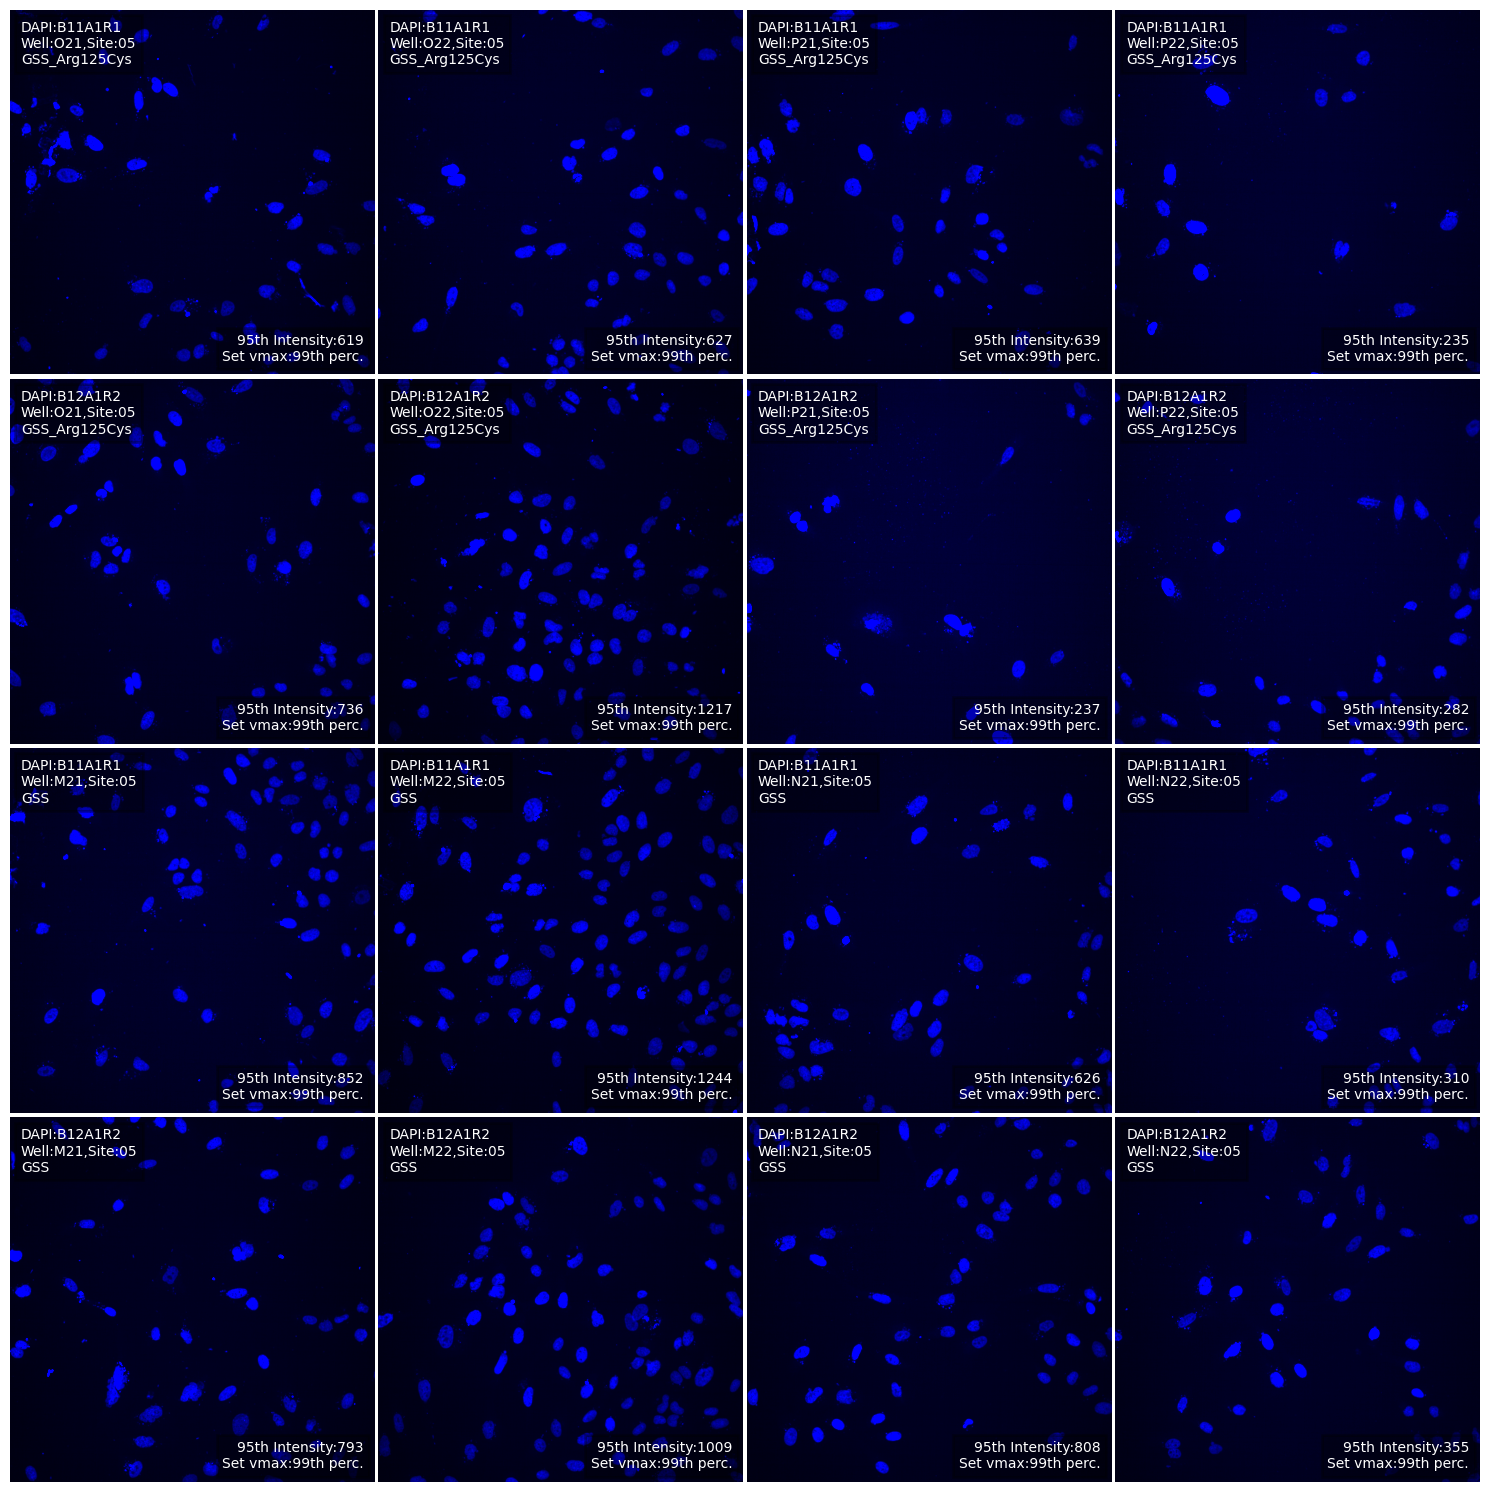

In [20]:
plot_allele_single_plate(allele_meta_df_dict["2024_12_Batch_11-12"], "GSS_Arg125Cys", "DAPI", 
            plate_img_qc=img_well_qc_sum_dict["2024_12_Batch_11-12"].with_columns(
                pl.col("channel").replace("DNA", "DAPI").alias("channel")
            ),
            site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

In [21]:
well_cc_stats_final

Gene,Variant,U2OS_cc_t_stat,U2OS_cc_t_pval
str,str,f64,f64
"""GRN""","""GRN_Ser120Tyr""",-2.826788,0.033279
"""AGXT""","""AGXT_Asp201Asn""",-3.224554,0.25889
"""DES""","""DES_Pro419Ser""",0.131902,1.0
"""AGXT""","""AGXT_Ile340Met""",0.355686,1.0
"""FARS2""","""FARS2_Asn280Ser""",-1.565581,1.0
…,…,…,…
"""F9""","""F9_Pro333Leu""",-4.019592,0.010125
"""F9""","""F9_Glu54Val""",-4.798264,0.004891
"""BRAF""","""BRAF_Gly596Val""",2.225713,0.061358


In [25]:
# Total number of increase vs. decrease
total = well_cc_stats_final.shape[0]

## We are comparing REF - VAR in the paired_ttest ttest_rel
## The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
## Thus, t-stat < 0 means REF more than VAR --> VAR decreasing CC
per_dec = well_cc_stats_final.filter(pl.col("U2OS_cc_t_stat") < 0).shape[0]
per_inc = well_cc_stats_final.filter(pl.col("U2OS_cc_t_stat") > 0).shape[0]

print("Total decreasin vs increasing percent:")
print(f"{per_dec}, {per_dec / total * 100:.2f} %")
print(f"{per_inc}, {per_inc / total * 100:.2f} %")

dec_sig = well_cc_stats_final.filter(pl.col("U2OS_cc_t_pval") < 0.05).filter(pl.col("U2OS_cc_t_stat") < 0).shape[0]
inc_sig = well_cc_stats_final.filter(pl.col("U2OS_cc_t_pval") < 0.05).filter(pl.col("U2OS_cc_t_stat") > 0).shape[0]

print("Number sig decreases")
print(f"{dec_sig}, {dec_sig / total * 100:.2f} %")
print("Number sig increases")
print(f"{inc_sig}, {inc_sig / total * 100:.2f} %")

Total decreasin vs increasing percent:
565, 53.55 %
488, 46.26 %
Number sig decreases
256, 24.27 %
Number sig increases
208, 19.72 %


In [26]:
# well_cc_stats_final.write_csv(f"{CC_ABUND_DIR}/cell_count_diff_summary.csv")